In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import math

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models, metrics
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, RandomFlip, BatchNormalization, Activation,
    RandomBrightness, RandomContrast, RandomZoom, RandomRotation, Rescaling, Lambda
)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as k

# from tensorflow.keras.applications.resnet import ResNet50, preprocess_input

In [2]:
DATASET_DIR = "dataset"
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 200
N_SPLITS = 5
SEED = 1000
MODEL = 'Modelo Proposto'

In [ ]:
def build_cnn():
    k.clear_session()

    data_augmentation = models.Sequential([
        RandomFlip(mode="horizontal", seed=SEED),
        RandomBrightness(factor=0.2, seed=SEED),
        RandomContrast(factor=0.2, seed=SEED),
        RandomRotation(factor=0.2, seed=SEED),
        RandomZoom(0.2, seed=SEED)
    ])

    model = models.Sequential([
        Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
        data_augmentation,
        Rescaling(1./255),
        Conv2D(filters=32, kernel_size=(3, 3), kernel_initializer="he_normal", padding="same"),
        BatchNormalization(),
        Activation("relu"),
        Dropout(0.1),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(filters=64, kernel_size=(5, 5), kernel_initializer="he_normal", padding="same"),
        BatchNormalization(),
        Activation("relu"),
        Dropout(0.1),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(filters=112, kernel_size=(3, 3), kernel_initializer="he_normal", padding="same"),
        BatchNormalization(),
        Activation("relu"),
        Dropout(0.1),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(filters=160, kernel_size=(7, 7), kernel_initializer="he_normal", padding="same"),
        BatchNormalization(),
        Activation("relu"),
        Dropout(0.1),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(filters=176, kernel_size=(7, 7), kernel_initializer="he_normal", padding="same"),
        BatchNormalization(),
        Activation("relu"),
        Dropout(0.1),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(units=544, activation="relu",),
        Dropout(0.1),
        Dense(units=800, activation="relu",),
        Dropout(0.15),
        Dense(units=1, activation="sigmoid")
    ])

    # model.load_weights('checkpoint-teste-5.weights.h5')

    optimizer = Adam(learning_rate=1e-4)
    
    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=[metrics.BinaryAccuracy(name='accuracy')])
    
    return model

In [4]:
model = build_cnn()
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 112)    │        64,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 112)    │           448 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 56, 56, 112)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 56, 56, 112)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 112)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 160)    │       878,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28, 28, 160)    │           640 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 28, 28, 160)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 28, 28, 160)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 160)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 14, 14, 176)    │     1,380,01

 Total params: 7,506,017 (28.63 MB)

 Trainable params: 7,504,929 (28.63 MB)

 Non-trainable params: 1,088 (4.25 KB)

In [11]:
datagen = ImageDataGenerator()

data_flow = datagen.flow_from_directory(
    DATASET_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

X, y = [], []
for i in range(len(data_flow)):
    imgs, labels = data_flow[i]
    X.append(imgs)
    y.append(labels)
    if (i+1)*BATCH_SIZE >= data_flow.samples:
        break

X = np.vstack(X)
y = np.hstack(y).astype(int)

print("Dataset carregado:", X.shape, y.shape)

Found 1265 images belonging to 2 classes.
Dataset carregado: (1265, 224, 224, 3) (1265,)


In [12]:
orig_class_indices = dict(data_flow.class_indices)
print("Mapeamento original:", orig_class_indices)

# Keras geralmente mapeia em ordem alfabética: bleached=0, unbleached=1.
# Queremos padronizar: unbleached=0, bleached=1
if orig_class_indices.get('bleached', None) == 0:
    print("⚠️ 'bleached' está como 0. Invertendo labels para padronizar bleached=1.")
    y = 1 - y
    class_indices = {'unbleached': 0, 'bleached': 1}
else:
    class_indices = orig_class_indices

inv_class_indices = {v: k for k, v in class_indices.items()}
label_names = [inv_class_indices[0], inv_class_indices[1]]  # ["unbleached","bleached"]
print("Mapeamento efetivo utilizado:", class_indices)

Mapeamento original: {'bleached': 0, 'unbleached': 1}
⚠️ 'bleached' está como 0. Invertendo labels para padronizar bleached=1.
Mapeamento efetivo utilizado: {'unbleached': 0, 'bleached': 1}



===== Fold 1 =====
Epoch 1/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/step - accuracy: 0.6789 - loss: 0.6384 - val_accuracy: 0.6443 - val_loss: 0.5982 - learning_rate: 1.0000e-04
Epoch 2/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.7332 - loss: 0.5458 - val_accuracy: 0.5573 - val_loss: 0.6721 - learning_rate: 1.0000e-04
Epoch 3/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.7846 - loss: 0.4607 - val_accuracy: 0.5929 - val_loss: 0.6731 - learning_rate: 1.0000e-04
Epoch 4/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.7866 - loss: 0.4548 - val_accuracy: 0.5692 - val_loss: 0.8083 - learning_rate: 1.0000e-04
Epoch 5/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.8103 - loss: 0.4476 - val_accuracy: 0.5415 - val_loss: 0.9737 - learning_rate: 1.0000e-04
Epoch 6/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.7994 - loss: 0.4296 - val_accuracy: 0.5375 - val_loss: 1.2078 - learning_rate: 1.0000e-04
Epoch 7/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step

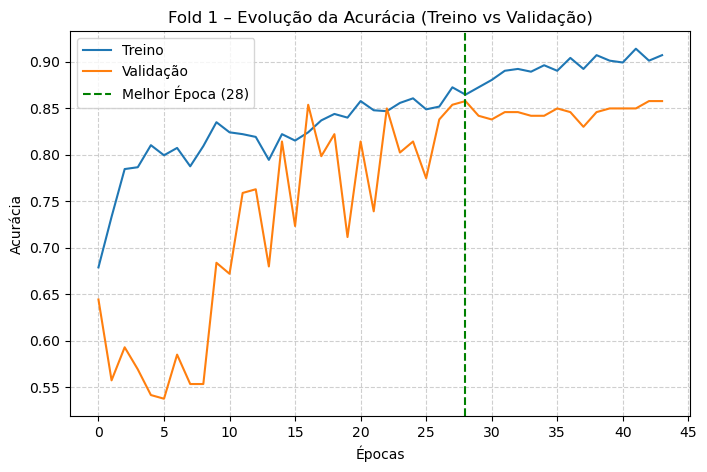

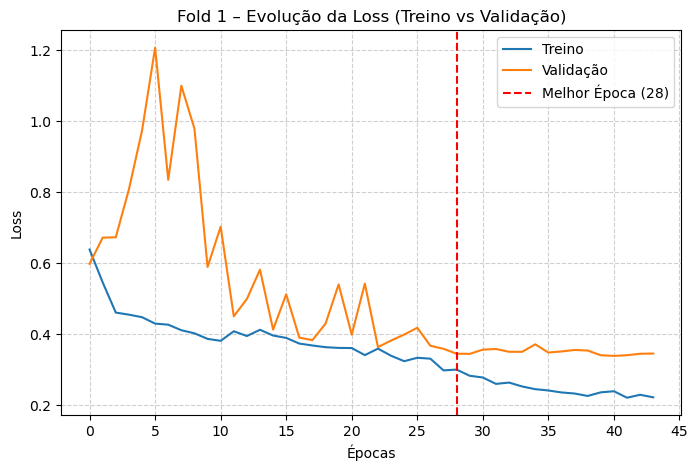

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 251ms/step
Acurácia: 0.8577, Precisão (bleached): 0.8356, Recall (bleached): 0.9104, F1 (bleached): 0.8714, Loss: 0.3446

===== Fold 2 =====
Epoch 1/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/step - accuracy: 0.6887 - loss: 0.6760 - val_accuracy: 0.5929 - val_loss: 0.6576 - learning_rate: 1.0000e-04
Epoch 2/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.7549 - loss: 0.4856 - val_accuracy: 0.5375 - val_loss: 0.7572 - learning_rate: 1.0000e-04
Epoch 3/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.7846 - loss: 0.4674 - val_accuracy: 0.5534 - val_loss: 0.7898 - learning_rate: 1.0000e-04
Epoch 4/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.7846 - loss: 0.4574 - val_accuracy: 0.5336 - val_loss: 0.8882 - learning_rate: 1.0000e-04
Epoch 5/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.7945 - loss: 0.4345 - val_accuracy: 0.6008 - val_loss: 0.7471 - learning_rate: 1.0000e-04
Epoch 6/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - acc

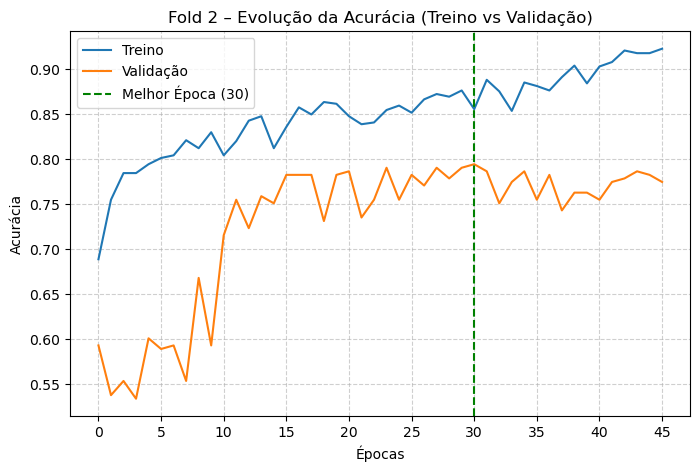

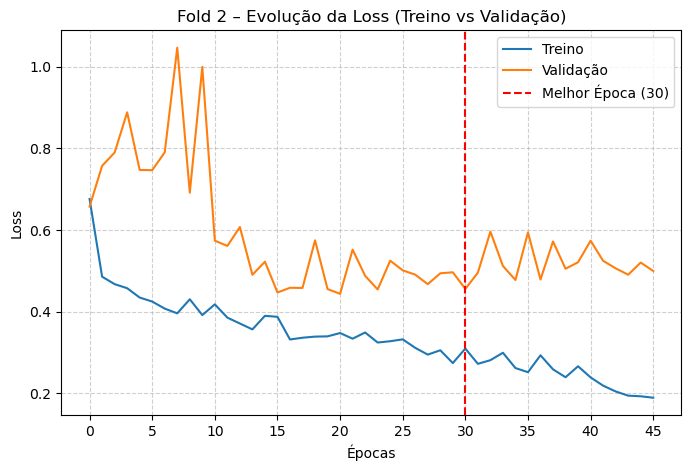

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 251ms/step
Acurácia: 0.7945, Precisão (bleached): 0.7971, Recall (bleached): 0.8209, F1 (bleached): 0.8088, Loss: 0.4557

===== Fold 3 =====
Epoch 1/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - accuracy: 0.6601 - loss: 0.7078 - val_accuracy: 0.5968 - val_loss: 0.6643 - learning_rate: 1.0000e-04
Epoch 2/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.7648 - loss: 0.4936 - val_accuracy: 0.5692 - val_loss: 0.7098 - learning_rate: 1.0000e-04
Epoch 3/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.7520 - loss: 0.5019 - val_accuracy: 0.5455 - val_loss: 0.7855 - learning_rate: 1.0000e-04
Epoch 4/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.7945 - loss: 0.4429 - val_accuracy: 0.5336 - val_loss: 0.9412 - learning_rate: 1.0000e-04
Epoch 5/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.8043 - loss: 0.4346 - val_accuracy: 0.5573 - val_loss: 0.8698 - learning_rate: 1.0000e-04
Epoch 6/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - acc

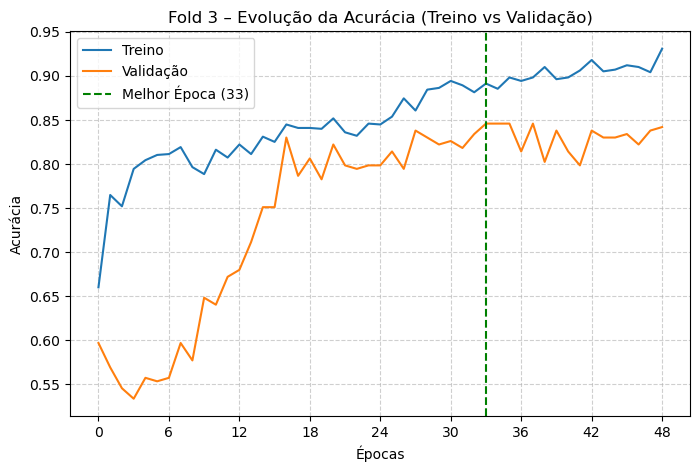

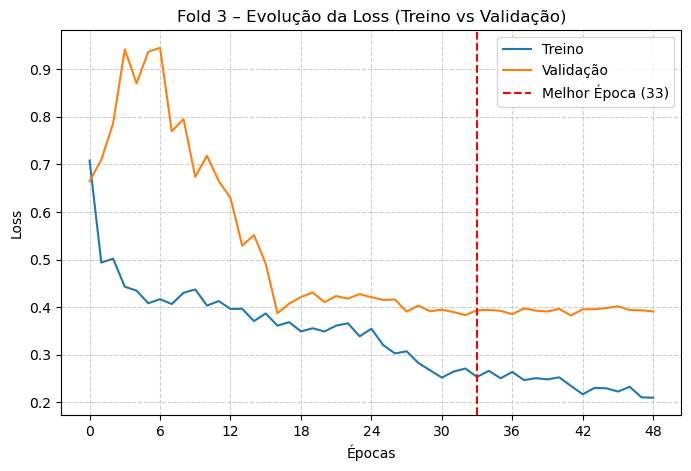

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 251ms/step
Acurácia: 0.8458, Precisão (bleached): 0.8862, Recall (bleached): 0.8134, F1 (bleached): 0.8482, Loss: 0.3936

===== Fold 4 =====
Epoch 1/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - accuracy: 0.7026 - loss: 0.6479 - val_accuracy: 0.7273 - val_loss: 0.5655 - learning_rate: 1.0000e-04
Epoch 2/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.7609 - loss: 0.5033 - val_accuracy: 0.7233 - val_loss: 0.5611 - learning_rate: 1.0000e-04
Epoch 3/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.7915 - loss: 0.4701 - val_accuracy: 0.5455 - val_loss: 0.7541 - learning_rate: 1.0000e-04
Epoch 4/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.7875 - loss: 0.4527 - val_accuracy: 0.5534 - val_loss: 0.7839 - learning_rate: 1.0000e-04
Epoch 5/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.8172 - loss: 0.4284 - val_accuracy: 0.6206 - val_loss: 0.6751 - learning_rate: 1.0000e-04
Epoch 6/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - acc

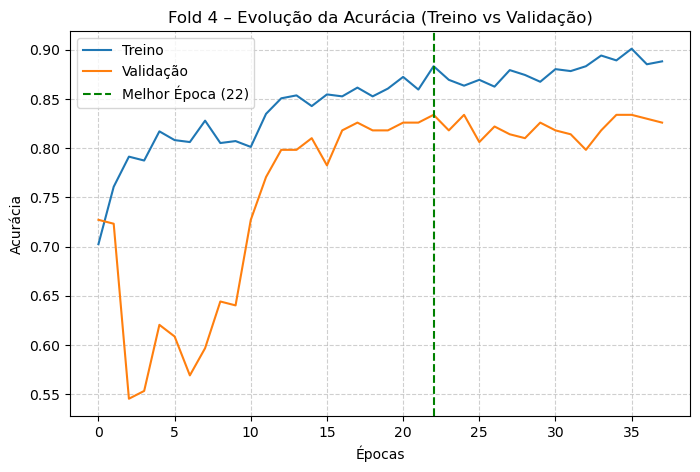

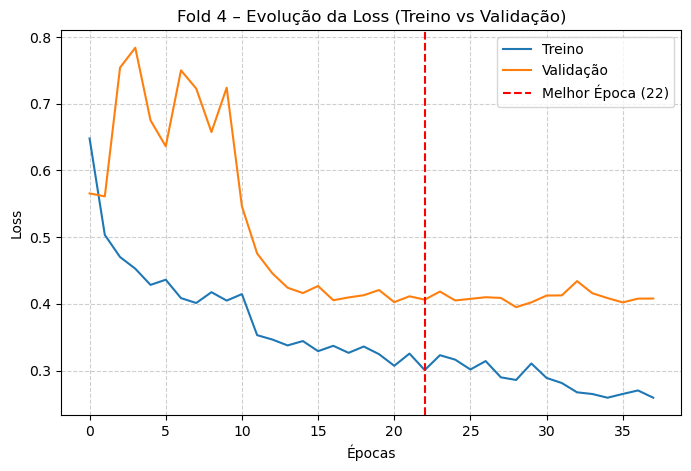

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 251ms/step
Acurácia: 0.8340, Precisão (bleached): 0.8333, Recall (bleached): 0.8582, F1 (bleached): 0.8456, Loss: 0.4062

===== Fold 5 =====
Epoch 1/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - accuracy: 0.6808 - loss: 0.6737 - val_accuracy: 0.5099 - val_loss: 0.7490 - learning_rate: 1.0000e-04
Epoch 2/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.7787 - loss: 0.5000 - val_accuracy: 0.5296 - val_loss: 0.8763 - learning_rate: 1.0000e-04
Epoch 3/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.7747 - loss: 0.4843 - val_accuracy: 0.5692 - val_loss: 0.6859 - learning_rate: 1.0000e-04
Epoch 4/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.7757 - loss: 0.4744 - val_accuracy: 0.5573 - val_loss: 0.8880 - learning_rate: 1.0000e-04
Epoch 5/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.7866 - loss: 0.4473 - val_accuracy: 0.5336 - val_loss: 0.9726 - learning_rate: 1.0000e-04
Epoch 6/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - acc

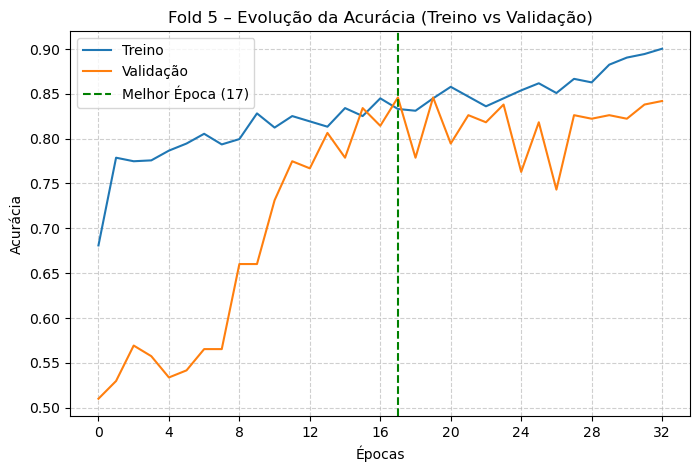

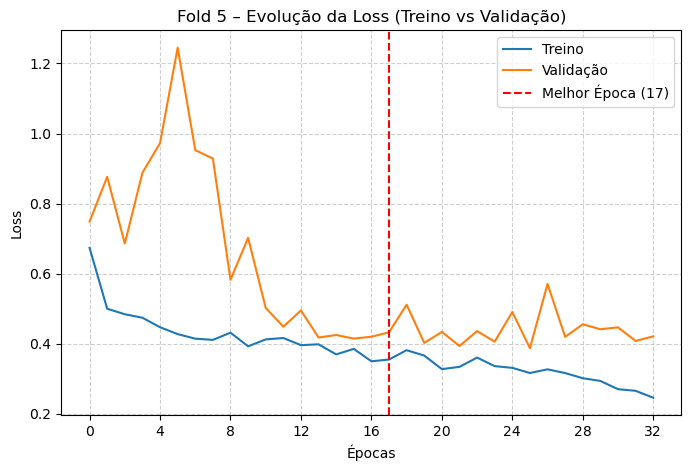

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 285ms/step
Acurácia: 0.8458, Precisão (bleached): 0.8264, Recall (bleached): 0.8947, F1 (bleached): 0.8592, Loss: 0.4328


In [ ]:
skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=42)

results = {"accuracy": [], "precision": [], "recall": [], "f1": [], "loss": []}
conf_matrices = []

fold = 1
for train_idx, test_idx in skf.split(X, y):
    print(f"\n===== Fold {fold} =====")
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    model = build_cnn()

    early_stopping = EarlyStopping(
        monitor='val_accuracy',
        patience=15,
        mode='max',
        restore_best_weights=True,
        verbose=1
    )

    rlr = ReduceLROnPlateau(monitor="val_accuracy", factor=0.2, patience=10, verbose=True)

    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        callbacks=[early_stopping, rlr],
        verbose=1
    )

    # --- Melhor época (baseada na maior val_accuracy) ---
    best_epoch = np.argmax(history.history['val_accuracy'])

    # --- Gráfico de treino vs validação - Acurácia ---
    plt.figure(figsize=(8, 5))
    plt.plot(history.history['accuracy'], label='Treino')
    plt.plot(history.history['val_accuracy'], label='Teste')
    plt.title(f'Fold {fold} – Evolução da Acurácia (Treino vs Teste)')
    plt.xlabel('Épocas')
    plt.ylabel('Acurácia')
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.6)

    # Forçar eixo X em inteiros
    ax = plt.gca()
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

    # Linha vertical na melhor época
    plt.axvline(x=best_epoch, color='green', linestyle='--', label=f'Melhor Época ({best_epoch})')

    plt.legend()
    plt.show()


    # --- Gráfico de treino vs validação - Loss ---
    plt.figure(figsize=(8, 5))
    plt.plot(history.history['loss'], label='Treino')
    plt.plot(history.history['val_loss'], label='Teste')
    plt.title(f'Fold {fold} – Evolução da Loss (Treino vs Teste)')
    plt.xlabel('Épocas')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.6)

    # Forçar eixo X em inteiros
    ax = plt.gca()
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

    # Linha vertical na melhor época (mesma usada na acurácia)
    plt.axvline(x=best_epoch, color='red', linestyle='--', label=f'Melhor Época ({best_epoch})')

    plt.legend()
    plt.show()

    # Predições
    y_pred_prob = model.predict(X_test)
    y_pred = (y_pred_prob.ravel() >= 0.5).astype(int)

    # Métricas
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, pos_label=1, zero_division=0)
    rec  = recall_score(y_test, y_pred, pos_label=1, zero_division=0)
    f1   = f1_score(y_test, y_pred, pos_label=1, zero_division=0)
    loss = model.evaluate(X_test, y_test, verbose=0)[0]

    print(f"Acurácia: {acc:.4f}, Precisão (bleached): {prec:.4f}, Recall (bleached): {rec:.4f}, F1 (bleached): {f1:.4f}, Loss: {loss:.4f}")

    results["accuracy"].append(acc)
    results["precision"].append(prec)
    results["recall"].append(rec)
    results["f1"].append(f1)
    results["loss"].append(loss)

    cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
    conf_matrices.append(cm)

    fold += 1

In [22]:
print("\n===== MÉDIAS DOS RESULTADOS DOS FOLDS =====")
for metric in results.keys():
    print(f"{metric.capitalize()}: {np.mean(results[metric]):.4f} (+/- {np.std(results[metric]):.4f})")



===== MÉDIAS DOS RESULTADOS DOS FOLDS =====
Accuracy: 0.8356 (+/- 0.0219)
Precision: 0.8357 (+/- 0.0287)
Recall: 0.8595 (+/- 0.0386)
F1: 0.8467 (+/- 0.0210)
Loss: 0.4066 (+/- 0.0377)


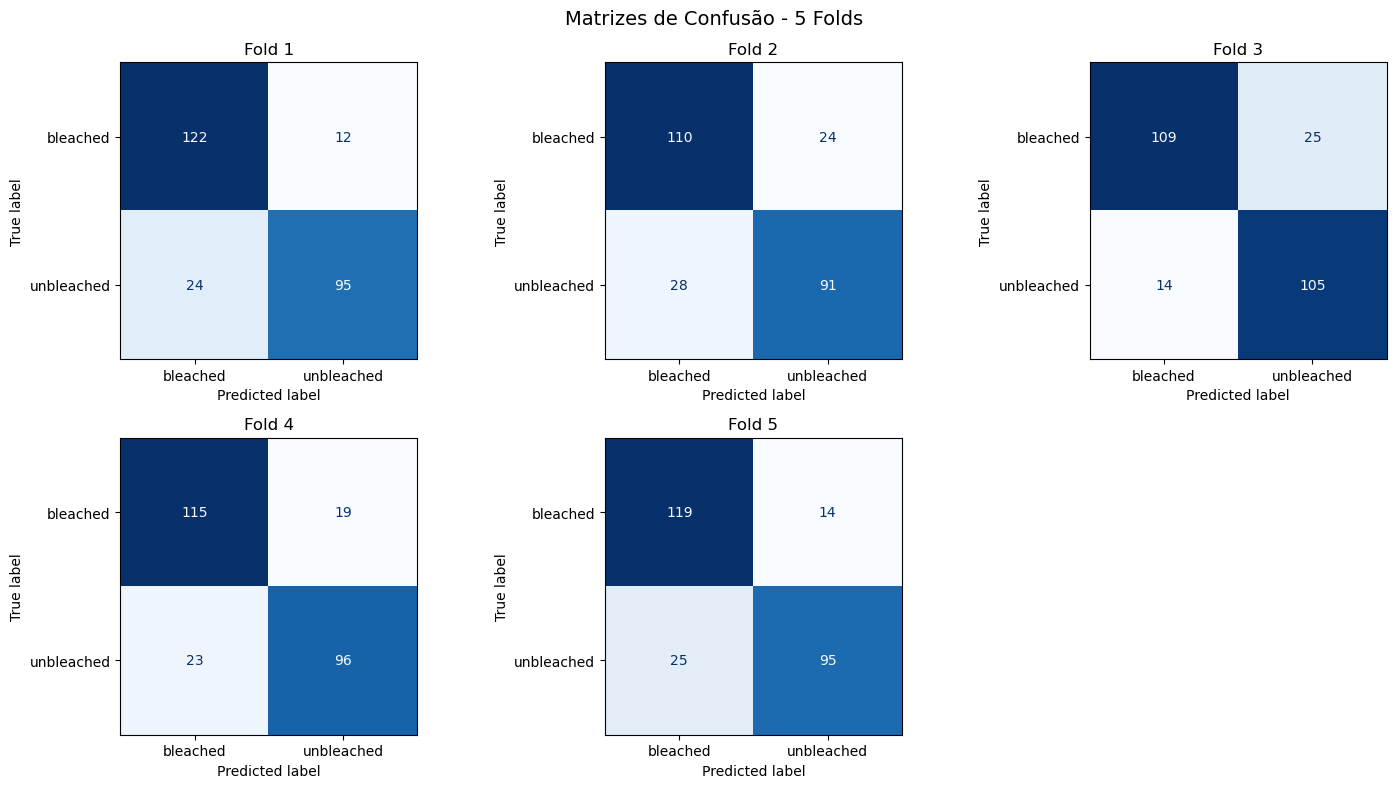

In [19]:
n = len(conf_matrices)
ncols = 3 if n > 2 else n
nrows = math.ceil(n / ncols)

fig, axes = plt.subplots(nrows, ncols, figsize=(5*ncols, 4*nrows))
if nrows == 1 and ncols == 1:
    axes = np.array([axes])
axes = axes.flatten() if isinstance(axes, np.ndarray) else [axes]

for i, cm in enumerate(conf_matrices):
    # Reorganiza a matriz para ter TP no canto superior esquerdo (classe 1)
    cm_reordered = np.array([[cm[1,1], cm[1,0]],
                             [cm[0,1], cm[0,0]]])
    
    disp = ConfusionMatrixDisplay(confusion_matrix=cm_reordered, display_labels=["bleached", "unbleached"])
    disp.plot(cmap="Blues", ax=axes[i], colorbar=False)
    axes[i].set_title(f"Fold {i+1}")

# Remove subplots vazios se existirem
for j in range(len(conf_matrices), len(axes)):
    fig.delaxes(axes[j])

plt.suptitle(f"Matrizes de Confusão - {n} Folds", fontsize=14)
plt.tight_layout()
plt.show()

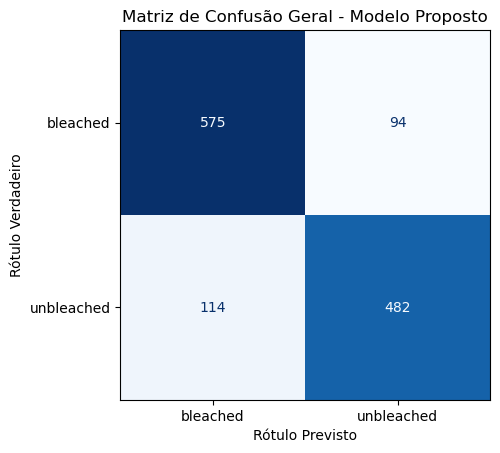

In [20]:
cm_total = sum(conf_matrices)

# Reordena para que 'bleached' (classe positiva) apareça primeiro
# assumindo que label_names = ["unbleached", "bleached"]
labels_ordered = ["bleached", "unbleached"]
cm_total_reordered = confusion_matrix(
    y_true=[], y_pred=[],  # truques para reordenar
    labels=labels_ordered
)
cm_total_reordered = cm_total[[1,0]][:,[1,0]]  # reorganiza manualmente

# Plot
disp = ConfusionMatrixDisplay(confusion_matrix=cm_total_reordered,
                              display_labels=labels_ordered)
disp.plot(cmap="Blues", colorbar=False)

plt.title(f"Matriz de Confusão Geral - {MODEL}")
plt.xlabel("Rótulo Previsto")
plt.ylabel("Rótulo Verdadeiro")

plt.show()

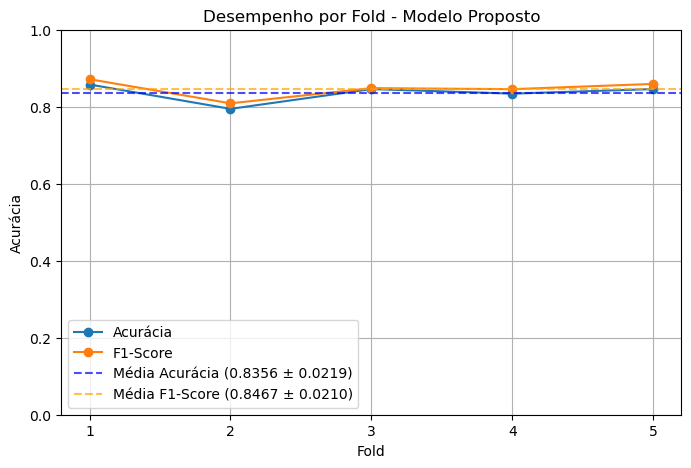

In [21]:
folds = np.arange(1, N_SPLITS+1)

acc_mean = np.mean(results["accuracy"])
acc_std = np.std(results["accuracy"])
f1_mean = np.mean(results["f1"])
f1_std = np.std(results["f1"])

plt.figure(figsize=(8,5))

# Curvas por fold
plt.plot(folds, results["accuracy"], marker="o", label="Acurácia")
plt.plot(folds, results["f1"], marker="o", label="F1-Score")

# Linhas horizontais das médias
plt.axhline(acc_mean, color="blue", linestyle="--", alpha=0.7, label=f"Média Acurácia ({acc_mean:.4f} ± {acc_std:.4f})")
plt.axhline(f1_mean, color="orange", linestyle="--", alpha=0.7, label=f"Média F1-Score ({f1_mean:.4f} ± {f1_std:.4f})")

# Configurações do gráfico
plt.title(f"Desempenho por Fold - {MODEL}")
plt.xlabel("Fold")
plt.ylabel("Acurácia")
plt.xticks(folds)
plt.ylim(0, 1)
plt.legend(loc="lower left")
plt.grid(True)
plt.show()